# Custom Loss Function in Tensorflow 2. 

> In this post, we will learn how to build custom loss functions with function and class. This is the summary of lecture "Custom Models, Layers and Loss functions with Tensorflow" from DeepLearning.AI.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow, DeepLearning.AI]
- image: images/huber_loss_ex.png

## Packages

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Part 1 - Huber Loss

In this section, we'll walk through how to create custom loss functions. In particular, we'll code the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) and use that in training the model.

### Prepare the Data

Our dummy dataset is just a pair of arrays `xs` and `ys` defined by the relationship $y = 2x - 1$. `xs` are the inputs while `ys` are the labels.

In [2]:
# inputs
xs = np.array([-1.0, 0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
# labels
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

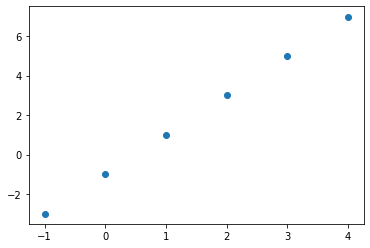

In [3]:
plt.scatter(xs, ys);

### Training the model

Let's build a simple model and train using a built-in loss function like the `mean_squared_error`.

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[1])
])

model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(xs, ys, epochs=500, verbose=0)

In [5]:
y_mse = model.predict([10.0])
y_mse

array([[18.978544]], dtype=float32)

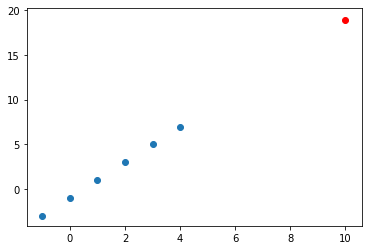

In [6]:
plt.scatter(xs, ys)
plt.scatter(10.0, y_mse, c='r');

### Training with Custom Loss

Now let's see how we can use a custom loss. We first define a function that accepts the ground truth labels (`y_true`) and model predictions (`y_pred`) as parameters. We then compute and return the loss value in the function definition.

The definition of Huber Loss is like this:

$$
L_{\delta}(a) = 
\begin{cases}
    \frac{1}{2} (y - f(x))^2 \quad & \text{ for } \vert a \vert \le \delta, \\
    \delta (\vert y - f(x) \vert - \frac{1}{2} \delta) \quad & \text{ otherwise} \\
\end{cases}
$$

In [7]:
def my_huber_loss(y_true, y_pred):
    threshold = 1.
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= threshold
    small_error_loss = tf.square(error) / 2
    big_error_loss = threshold * (tf.abs(error) - threshold / 2)
    return tf.where(is_small_error, small_error_loss, big_error_loss)

Using the loss function is as simple as specifying the loss function in the `loss` argument of `model.compile()`.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1,])
])

model.compile(optimizer='sgd', loss=my_huber_loss)
model.fit(xs, ys, epochs=500, verbose=0)

In [9]:
y_hl = model.predict([10.0])
y_hl

array([[18.722095]], dtype=float32)

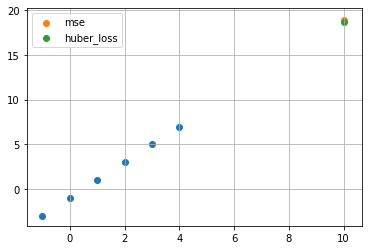

In [10]:
plt.scatter(xs, ys);
plt.scatter(10.0, y_mse, label='mse');
plt.scatter(10.0, y_hl, label='huber_loss');
plt.grid()
plt.legend();

## Part 2 - Huber Loss Hyperparameter and Loss class

In this section, we'll extend our previous Huber loss function and show how you can include hyperparameters in defining loss functions. We'll also look at how to implement a custom loss as an object by inheriting the [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss) class.

### Prepare the Data

As before, this model will be trained on the `xs` and `ys` below where the relationship is $y = 2x-1$. Thus, later, when we test for `x=10`, whichever version of the model gets the closest answer to `19` will be deemed more accurate.

### Custom loss with hyperparameter

The `loss` argument in `model.compile()` only accepts functions that accepts two parameters: the ground truth (`y_true`) and the model predictions (`y_pred`). If we want to include a hyperparameter that we can tune, then we can define a wrapper function that accepts this hyperparameter.

In [11]:
# wrapper function that accepts the hyperparameter
def my_huber_loss_with_threshold(threshold):
    # function that accepts the ground truth and predictions
    def my_huber_loss(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = threshold * (tf.abs(error) - (threshold / 2))
        return tf.where(is_small_error, small_error_loss, big_error_loss)
    # return the inner function tuned by the hyperparameter
    return my_huber_loss

We can now specify the `loss` as the wrapper function above. Notice that we can now set the `threshold` value. Try varying this value and see the results you get.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[1])
])

model.compile(optimizer='sgd', loss=my_huber_loss_with_threshold(threshold=1.2))
model.fit(xs, ys, epochs=500, verbose=0)

In [13]:
y_hlt = model.predict([10.0])
y_hlt

array([[18.618975]], dtype=float32)

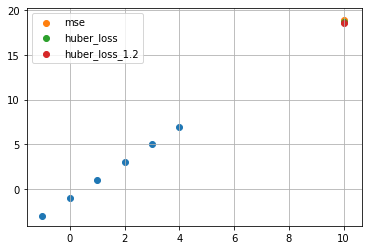

In [14]:
plt.scatter(xs, ys);
plt.scatter(10.0, y_mse, label='mse');
plt.scatter(10.0, y_hl, label='huber_loss');
plt.scatter(10.0, y_hlt, label='huber_loss_1.2')
plt.grid()
plt.legend();

### Implement Custom Loss as a Class

We can also implement our custom loss as a class. It inherits from the Keras Loss class and the syntax and required methods are shown below.

In [15]:
from tensorflow.keras.losses import Loss

class MyHuberLoss(Loss):
    # initialize instance attributes
    def __init__(self, threshold=1):
        super(MyHuberLoss, self).__init__()
        self.threshold = threshold
        
    # Compute loss
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - self.threshold / 2)
        return tf.where(is_small_error, small_error_loss, big_error_loss)

You can specify the loss by instantiating an object from your custom loss class.

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[1,])
])

model.compile(optimizer='sgd', loss=MyHuberLoss(threshold=1.02))
model.fit(xs, ys, epochs=500, verbose=0)

In [17]:
y_hltc = model.predict([10.0])
y_hltc

array([[18.58202]], dtype=float32)